<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning/blob/main/HW_23_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Обучение алгоритма REINFORCE

Алгоритм учится играть в игру **Assault**.

**Правила игры**

In [ ]:
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l7/Roms.zip', None, quiet = True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l7/pretrained.zip', None, quiet = True)

'pretrained.zip'

In [ ]:
# Создание директории ROM
!mkdir /content/ROM/

In [ ]:
# Распаковка архива
!unzip -q Roms.zip -d ROM

In [ ]:
!python -m atari_py.import_roms /content/ROM/     #атари - названии группы игр

In [ ]:
!unzip -q pretrained.zip

Импортируем все нужные модули и библиотеки, подключаемся к диску:

In [ ]:
# Библиотека Gym (встроенная в Colab)
import gym     

import numpy as np 
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.layers import * 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPooling2D, Input, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop 
import tensorflow as tf     
import matplotlib.pyplot as plt
import pickle  
from moviepy.editor import *   
import cv2           
from google.colab import output            

In [ ]:
# Создаем среду Pong
env = gym.make('AssaultDeterministic-v4')   # отчет каждые 4 кадра

# Запускаем среду (это действие возвращает начальное состояние)
new_frame = env.reset()        

# Взглянем на размерность состояния
print(f"Размерность состояния: {new_frame.shape}")     

Размерность состояния: (210, 160, 3)


###Возможные действия

In [ ]:
# Взглянем на все возможные действия и узнаем, что они делают 
env.unwrapped.get_action_meanings() 

['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

5,6 - агент стреляет влево и вправо, это не очень эффективно, для более быстрого обучения уберем эти действия

In [ ]:
# Создаем массив возможных действий. Агент может стоять на месте, двигаться влево или вправо - попробовать все действия
action_space = [0,1,2,3,4] 

# Записываем в переменную количество уникальных возможных действий — также известно как размерность пространства действий
num_actions = len(action_space) 

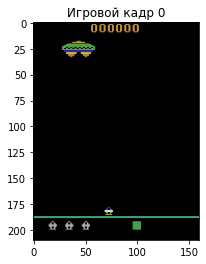

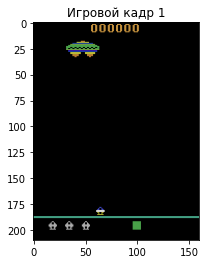

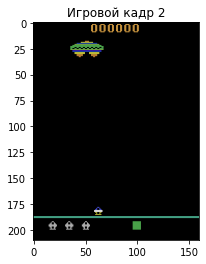

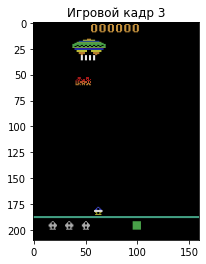

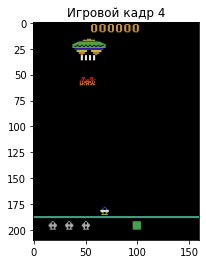

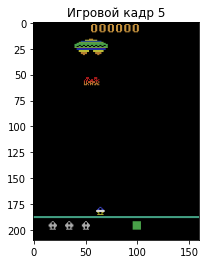

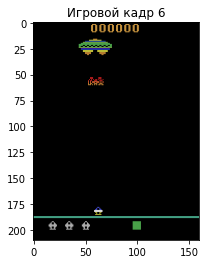

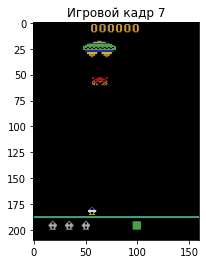

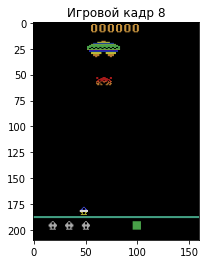

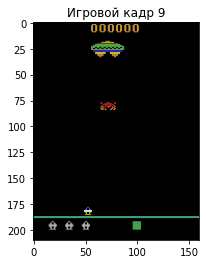

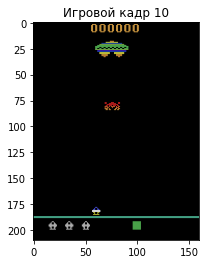

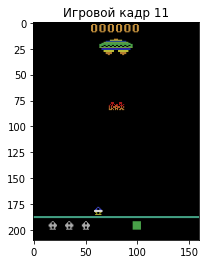

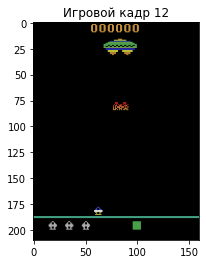

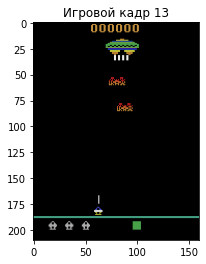

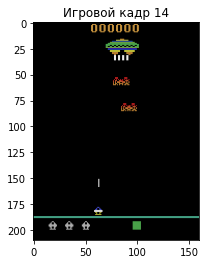

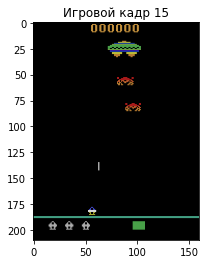

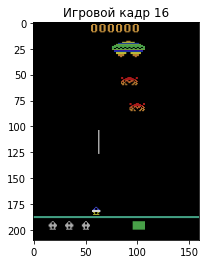

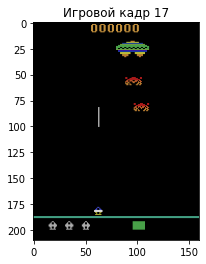

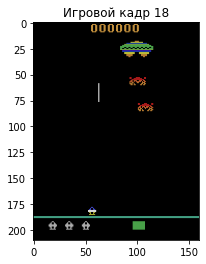

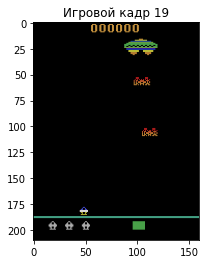

In [ ]:
# Начинаем новую игру
env.reset()         

# Запускаем цикл 20 раз
for i in range(20): 

  # Подаем рандомное действие на вход. На выходе получаем новую информацию о текущем состоянии игры
  new_frame, reward, done, misc = env.step(np.random.choice(action_space)) 
  
  # Рисуем изображения
  plt.imshow(new_frame)  
  
  # Добавляем заголовок                         
  plt.title(f"Игровой кадр {i}", fontsize = 12)  
  
  # Показываем изображения 
  plt.show()                                      

(array([  0.,  51.,  66.,  72., 110., 162., 167., 180., 181., 187., 214.],
      dtype=float32), array([6923,   14,   81,   25,   12,    5,   13,   17,   10,   16,    4]))
(array([0., 1.], dtype=float32), array([6923,  197]))


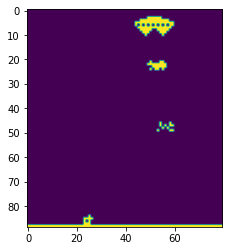

In [ ]:
frame = new_frame.copy()
frame = frame.astype(np.float32)
frame = frame[11:188]
frame = frame[::2, ::2, 0]
print(np.unique(frame, return_counts=True))
#frame[frame==48] = 0
#frame[frame==180] = 0
frame[frame != 0] = 1 
plt.imshow(frame)
#print(frame)
print(np.unique(frame, return_counts=True))

In [ ]:
frame.shape

(89, 80)

In [ ]:
input_shape = (89, 80, 2)

Создадим функцию для предобработки кадра — превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

In [ ]:
def preprocess_frame(frame):      

  ''' Функция предобработки кадра. 
      Превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

      Аргументы: 
      frame - кадр
      
  '''

  # Меняем тип данных на float32
  frame = frame.astype(np.float32) 
  
  # Отсекаем ненужные части кадра, которые не принадлежат игровому полю
  frame = frame[11:188]           

  # Сжимаем изображение (берем каждый второй пиксель) 
  frame = frame[::2, ::2, 0]       
  
  # Удаляем фон (меняем на черный цвет — значение пикселя = 0)
  #frame[frame == 144] = 0    

  # Удаляем фон (меняем на черный цвет — значение пикселя = 0)      
  #frame[frame == 180] = 0    

  # Всё, что не принадлежит фону, меняем на белый цвет (значение пикселя = 1)  
  frame[frame != 0] = 1            
  
  return frame.reshape(89, 80, 1)  # Меняем форму итогового кадра на (80, 80, 1)

Создадим функцию для склеивания двух кадров. Этот процесс даст нам текущее состояние, которое будет подаваться на вход нейронной сети.


In [ ]:
def stack_frames(new_frame, 
                 old_frame):                  
                 
  ''' Функция склеивания кадров 
      Превращает цвет в черно-белый, отсекает ненужные части кадра и сжимает.

      Аргументы: 
      new_frame — новый кадр
      old_frame — старый кадр
      
  '''

  # Предобрабатываем новое изображение (используем выше объявленную функцию)
  new_frame = preprocess_frame(new_frame)  
  
  # Предобрабатываем старое изображение (используем выше объявленную функцию)                
  old_frame = preprocess_frame(old_frame)                  
  
  return np.concatenate([new_frame, old_frame], axis = -1) # Склеиваем изображения по 3-й (канальной) оси, и возвращаем.

## Создание нейронной сети

Сеть принимает на вход состояние с размерностью `(80, 80, 2)`. На выходе будет слой с тремя нейронами, т. к. у нас три возможных действия, в которых будет содержаться вероятность принятия каждого действия.

In [ ]:
def create_model():                     

  ''' Функция создания модели '''

  input = Input(input_shape)             # Задаем входную размерность — (93, 80, 2)
  
  x = Flatten()(input)                   # Применяем выравнивающий слой
  x = Dense(1024, activation = 'elu')(x) # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  x = Dense(512, activation = 'elu')(x)  # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  
  output = Dense(num_actions, 
                 activation = 'softmax')(x) # Выходной слой, где считается вероятность совершения нужного действия

  # Создаем модель
  model = Model(input, output)   

  # Компилируем модель — используем оптимизатор RMSprop с низким шагом обучения
  model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy') 

  return model   

In [ ]:
def create_cv_model():                     

  ''' Функция создания модели '''

  input = Input(input_shape)             # Задаем входную размерность — (89, 80, 2)
  
  x = Conv2D(32,5, strides=(4,4), activation='relu')(input)                  
  x = Conv2D(64,3, strides=(2,2), activation='relu')(x)
  #x = Conv2D(128,3, strides=(2,2), activation='relu')(x)
  x = Flatten()(x)
  x = Dense(512, activation = 'elu')(x)  # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  
  output = Dense(num_actions, 
                 activation = 'softmax')(x) # Выходной слой, где считается вероятность совершения нужного действия

  # Создаем модель
  model = Model(input, output)   

  # Компилируем модель — используем оптимизатор RMSprop с низким шагом обучения
  model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy') 

  return model   

## Создание функций

### Выбор действия

Нейронная сеть выдает вероятности принятия каждого действия. Ниже созданная функция использует эти вероятности для выбора конкретного действия.

In [ ]:
def choose_action(state):     

  ''' Функция выбора действия 

      Аргументы: 
      state — состояние

  '''

  # Делаем предсказание
  probs = model.predict(state.reshape(1, 89, 80, 2))   
  
  # Выбираем индекс действия рандомно, используя предсказанные вероятности модели
  action_index = np.random.choice(num_actions, p = probs.flatten()) 
  
  # Возвращаем индекс рандомно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс)
  return action_index     

### Предобработка наград

В теоретической части урока упоминалось, что нам необходимо предобрабатывать награды для корректного обучения алгоритма. В данном случае у нас скудные награды, но мы должны предобработать их, чтобы какая-то награда назначалась за каждое действие.

In [ ]:
def preprocess_rewards(rewards_list):

  ''' Функция предобработки наград. 

      Аргументы: 
      rewards_list - состояние

  '''
  # Инициализируем массив обработанных наград нулями
  discounted_rewards = np.zeros_like(rewards_list)  

  # running_add содержит предобработанную награду, которая назначается за действие — инициализируется нулем    
  running_add = 0                                       
  
  # Итерируем через массив наград в обратном порядке
  for i in reversed(range(len(discounted_rewards))):    
    
    # Если на заданный момент есть ненулевая награда, которая была назначена средой 
    if rewards_list[i] != 0:                            
      # переменная running_add обнуляется
      running_add = 0                                   
    
    # Задаем награду за текущее действие (псевдо-уравнение Беллмана)
    running_add = gamma * running_add + rewards_list[i] 

    # Записываем награду в массив обработанных наград
    discounted_rewards[i] = running_add                 
    #discounted_r -= np.mean(discounted_r) #normalizing the result
    #discounted_r /= np.std(discounted_r) #idem using standar deviation
  # Возвращаем массив обработанных наград
  return discounted_rewards                  

In [ ]:
a = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

In [ ]:
gamma = 0.98
preprocess_rewards(a)

array([0.88584238, 0.9039208 , 0.92236816, 0.941192  , 0.9604    ,
       0.98      , 1.        , 0.83374776, 0.85076302, 0.86812553,
       0.88584238, 0.9039208 , 0.92236816, 0.941192  , 0.9604    ,
       0.98      , 1.        ])

In [ ]:
def show_scores(scores, 
                episode_durations):

  ''' Функция отображения наград за эпизод. 

      Аргументы: 
      scores -  
      episode_durations - 

  '''    

  # Удаляем предыдущий вывод ячейки
  output.clear() 

  # Устанавливаем большой размер полотна
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))    

  # Отрисовываем награды                        
  axes[0].plot(scores, linestyle = '--', label = 'Награда за эпизод')  

  # Считаем и отрисовываем скользящее среднее от награды        
  axes[0].plot(moving_average(scores), label = 'Скользящее среднее награды') 

  # Добавляем лейблы осей  
  axes[0].set_xlabel('Эпизод', fontsize = 12)                                  
  axes[0].set_ylabel('Награда', fontsize = 12)

  # Создаем легенду
  axes[0].legend()         
  
  # Отрисовываем длину эпизодов
  axes[1].plot(episode_durations, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')  
  
  # Считаем и отрисовываем скользящее среднее по длины эпизода
  axes[1].plot(moving_average(episode_durations), 'k', label = 'Длина эпизода (Скользящее среднее)')    
  
  # Добавляем лейблы осей
  axes[1].set_xlabel('Эпизод', fontsize = 12)                                                            
  axes[1].set_ylabel('Количество действий', fontsize = 12)
  
  # Создаем легенду
  axes[1].legend()         
  
  # Выводим график
  plt.show()

Также мы создадим функцию подсчета скользящего среднего всех значений. Это будет осуществляться через математическую свёртку, и мы будем считать скользящее среднее за 20 значений.

In [ ]:
def moving_average(data, 
                   width = 20): 

  ''' Функция подсчета скользящего среднего всех значений
      
      Аргументы:
      data — входной массив,
      width — длина, на которую считаем скользящее среднее
  '''

  # Длина свертки (минимум из заданной длины свертки и длины датасета)
  width = min(width, len(data))  

  # Вместо паддинга из нулей мы создадим паддинг для свертки из первого значения массива. Весь паддинг будет слева (в начале массива)    
  data = np.concatenate([np.repeat(data[0], width), data])  
   
  # Возвращаем результат свертки данных на фильтр из единиц — наше скользящее среднее
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  

используем сверточную сетку

In [ ]:
# Создаем модель, используя ранее объявленную функцию
model = create_cv_model() 

def train_model(episode_states, 
                episode_actions, 
                episode_rewards):
    
  ''' Функция для обучения модели 
  
      Аргументы:
      episode_states - 
      episode_actions - 
      episode_rewards -
  
  ''' 

  # Предобрабатываем награды, используя ранее объявленную функцию  
  rewards = preprocess_rewards(episode_rewards)  
  
  # Обучаем алгоритм на собранном пакете данных — одном полном эпизоде
  model.train_on_batch(episode_states, episode_actions, sample_weight = rewards) 

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 89, 80, 2)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 19, 32)        1632      
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 9, 64)         18496     
                                                                 
 flatten_5 (Flatten)         (None, 5760)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               2949632   
                                                                 
 dense_13 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 2,972,325
Trainable params: 2,972,325
Non-tra

До того, как мы начнем обучать алгоритм, нам осталось задать гиперпараметры. Также, если алгоритм уже обучался, и мы хотим продолжить обучение, загрузим предыдущую статистику и веса сохраненной модели.

В данной реализации алгоритма есть всего один гиперпараметр — гамма. Его нужно назначать с учетом скудности среды и игрового процесса. Практика показывает, что для этой среды 0.98 — это хорошее значение.

In [ ]:
# Гиперпараметр гамма 
gamma = 0.98 

Если переменная `load_pretrained` равна `True`, мы загружаем веса обученной модели и историю наград, и продолжаем обучение. Если она равна `False`, мы начинаем обучение с нуля.

In [ ]:
load_pretrained = False

In [ ]:
# Если load_pretrained равна True:
if load_pretrained:  

  # Открываем файл, используя функцию из pickle
  with open('/content/scores.txt', 'rb') as f: 
    
    # Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов и номер эпизода)
    all_scores, all_episode_durations, episode_number = pickle.load(f)   
  
  # Загружаем сохраненные веса
  model.load_weights('/content/REINFORCE.h5')  

# Иначе 
else:    

  # Инициализируем переменную за номер эпизода нулем                   
  episode_number = 0 

  # Инициализируем список, где будем хранить все награды (будет отображаться в качестве метрики)
  all_scores = []  

  # Инициализируем список, где будем хранить длину всех эпизодов (будет отображаться в качестве метрики)                   
  all_episode_durations = []          

## Создание игрового цикла и обучение агента



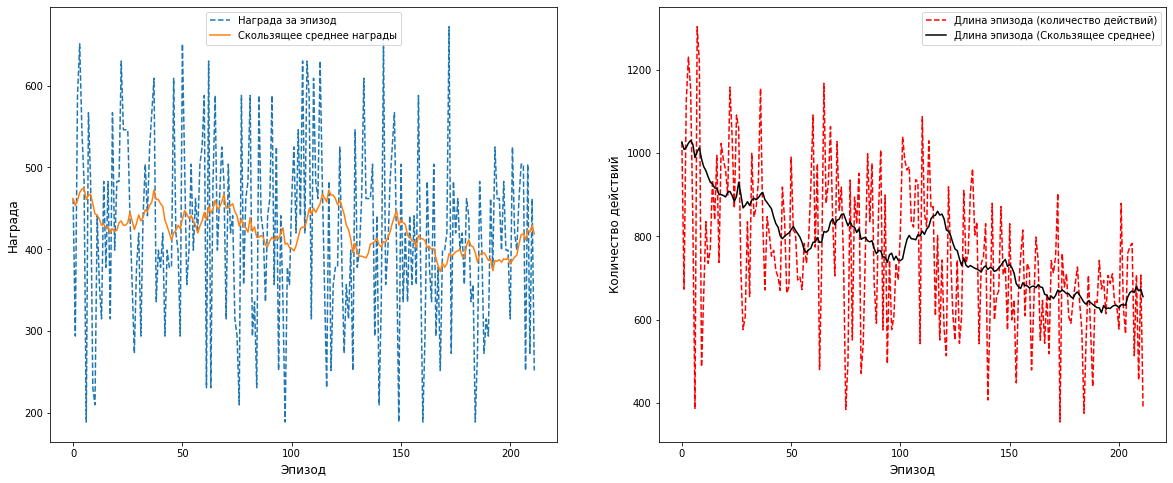

Закончен 212-й эпизод, счёт: (агент) 252.0, продолжительность игры: 391 кадров.


KeyboardInterrupt: ignored

In [ ]:
# Создаем среду SpaceInvaders
env = gym.make('AssaultDeterministic-v4')  

while episode_number < 501:

  # Список состояний одного эпизода (для обучения алгоритма)  
  episode_states = [] 

  # Список всех действий за эпизод (для обучения алгоритма)        
  episode_actions = [] 

  # Список всех наград за эпизод (для обучения алгоритма)       
  episode_rewards = []        
  
  # Запускаем среду (это действие возвращает начальное состояние)
  new_frame = env.reset()   

  # Инициализируем предыдущий кадр как текущий кадр       
  old_frame = new_frame            
  
  # Конкатенируем два кадра вместе, чтобы создать состояние
  state = stack_frames(new_frame, old_frame) 
  
  # done — переменная говорит, если игровой эпизод завершен. Инициализируется со значением False
  done = False      

  # Пока игровой эпизод не завершен
  while not done:       

    # Выбираем новое действие по текущему состоянию среды   
    action_index = choose_action(state)  

    # Подаем действие в среду, получаем новый кадр, награду, и узнаем, если игра окончена                                   
    new_frame, reward, done, misc = env.step(action_space[action_index])    
    
    # Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод
    episode_states.append(state)  

    # Добавляем действие в массив действий за эпизод                   
    episode_actions.append(action_index)  

    # Добавляем полученную награду в массив наград за эпизод           
    episode_rewards.append(reward)  

    # Создаем новое состояния, используя новый кадр (это нужно делать после добавления состояния в массив)                 
    state = stack_frames(new_frame, old_frame)       
    
    # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
    old_frame = new_frame            
  
  # Увеличиваем счетчик (который отвечает за номер эпизода) на 1.
  episode_number += 1

  # Длина эпизода (количество кадров в эпизоде) равна количеству состояний за эпизод                     
  episode_timesteps = len(episode_states) 
  
  # Переводим данные в NumPy-массивы
  episode_states, episode_actions, episode_rewards = np.array(episode_states), np.array(episode_actions), np.array(episode_rewards) 
  
  # Считаем количество положительных наград (равно количеству голов, который забил агент)
  points_won = np.sum(episode_rewards)   #оставить это - =[episode_rewards > 0].size  возможно лучшее обучение!!!
  
  # Считаем количество отрицательных наград (равно количеству голов, который пропустил агент)
  #points_lost = episode_rewards[episode_rewards < 0].size  

  # Обучаем модель, используя состояния в эпизоде, соответствующие действия и награды
  train_model(episode_states, episode_actions, episode_rewards) 
  
  # Очки за эпизод = количество забитых голов — количество пропущенных голов
  episode_score = points_won #- points_lost   

  # Добавляем количество очков в список (используется в качестве метрики)      
  all_scores.append(episode_score)     

  # Добавляем длину эпизода в список (используется в качестве метрики)            
  all_episode_durations.append(episode_timesteps)  
  
  # Отображаем метрики на графике
  show_scores(all_scores, all_episode_durations)   
  
  # Сохраняем прогресс раз в 10 эпизодов
  if episode_number % 10 == 0:    

    # Сохраняем веса модели
    model.save_weights('/content/REINFORCE.h5')   
    
    # Открываем файл, используя функцию из pickle
    with open('/content/scores.txt', 'wb') as f:  
      
      # Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл
      pickle.dump([all_scores, all_episode_durations, episode_number], f)    

  # Дополнительно выводим статистику за эпизод через print
  print(f"Закончен {episode_number}-й эпизод, счёт: (агент) {points_won}, продолжительность игры: {episode_timesteps} кадров.")

## Тестирование работы агента

Создадим функцию для выбора действия при тесте. Поскольку алгоритм уже не обучается, ему не нужно разведывать среду. 

В связи с этим есть смысл в создании альтернативной функции для выбора действия. Вместо предсказывания действий рандомным образом, используя вероятности, алгоритм предскажет действия напрямую. Так политика агента станет детерминированной.

In [ ]:
def choose_test_action(state):    
    
  ''' Функция выбора действия при тесте. 

      Аргументы: 
      state - состояние
      
  '''
  # Делаем предсказание
  probs = model.predict(state.reshape(1, 89, 80, 2))  
  
  # Вместо выбора действия рандомно, выбираем действие с максимальной вероятностью
  action_index = np.argmax(probs.flatten())           
  
  # Возвращаем индекс детерминированно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс)
  return action_index   

## Создание видео с игрой агента

Для создания видео мы сначала создадим массив (список), куда будем поочередно добавлять кадры из игрового эпизода. Затем, с помощью библиотеки `moviepy`, превратим массив из кадров — в видео.

In [ ]:
# Список для записи кадров из игр
video_frames = []   

# Создаем среду Pong
env = gym.make('AssaultDeterministic-v4')  

# Запускаем среду (это действие возвращает начальное состояние)  
new_frame = env.reset() 

# Инициализируем предыдущий кадр как текущий кадр
old_frame = new_frame      

# Конкатенируем два кадра вместе, чтобы создать состояние
state = stack_frames(new_frame, old_frame) 

# Done — переменная говорит, если игровой эпизод завершен. Инициализируется с значением False
done = False   

# Пока игровой эпизод не завершен
while not done:     

  # Выбираем новое действие по текущему состоянию среды детерминированным образом
  action_index = choose_test_action(state)                                   
  
  # Подаем действие в среду, получаем новый кадр (награда уже не нужна)
  new_frame, reward, done, misc = env.step(action_space[action_index])      
  
  # Добавляем новый кадр в массив кадров
  video_frames.append(new_frame)                     
  
  # Склеиваем новый и старый кадры вместе, чтобы создать новое состояние для подачи в нейросеть
  state = stack_frames(new_frame, old_frame)         
  
  # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
  old_frame = new_frame         

In [ ]:
# Создаем объект для воспроизведения видео
out = cv2.VideoWriter('/content/episode.avi',          # путь к файлу видео
                      cv2.VideoWriter_fourcc(*'DIVX'), # формат видео
                      30,                              # кадры в секунду: чем больше, тем быстрее проигрывается
                      (160, 210))                      # размер изображений
                       
# В цикле добавляем каждый кадр в видео (делаем предобработку кадра — меняем каналы с RGB в BGR, поскольку cv2 воспринимает каналы как BGR)
for i in range(len(video_frames)):   
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))

# Закрываем объект для создания видео
out.release()   

In [ ]:
# Указываем путь к видео
path="/content/episode.avi" 

# Извлекаем видео из заданного пути (куда мы ранее записали видео через cv2)
clip=VideoFileClip(path) 

# Отображаем видео в Colab
clip.ipython_display(width=320, maxduration = 1000) 

100%|██████████| 679/679 [00:00<00:00, 2443.38it/s]


вме

агент стоит на месте, причина непонятна. Попробуем полносвязную сеть вместо сверточной

In [ ]:
def create_model():                     

  ''' Функция создания модели '''

  input = Input((89, 80, 2))             # Задаем входную размерность — (80, 80, 2)
  
  x = Flatten()(input)                   # Применяем выравнивающий слой
  x = Dense(1024, activation = 'elu')(x) # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  x = Dense(512, activation = 'elu')(x)  # Полносвязный слой — эмпирическим методом выявлено, что с активационной функцией 'elu' сеть лучше обучается
  
  output = Dense(num_actions, 
                 activation = 'softmax')(x) # Выходной слой, где считается вероятность совершения нужного действия

  # Создаем модель
  model = Model(input, output)   

  # Компилируем модель — используем оптимизатор RMSprop с низким шагом обучения
  model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy') 

  return model   

In [ ]:
# Создаем модель, используя ранее объявленную функцию
model = create_model() 

def train_model(episode_states, 
                episode_actions, 
                episode_rewards):
    
  ''' Функция для обучения модели 
  
      Аргументы:
      episode_states - 
      episode_actions - 
      episode_rewards -
  
  ''' 

  # Предобрабатываем награды, используя ранее объявленную функцию  
  rewards = preprocess_rewards(episode_rewards)  
  
  # Обучаем алгоритм на собранном пакете данных — одном полном эпизоде
  model.train_on_batch(episode_states, episode_actions, sample_weight = rewards) 

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 89, 80, 2)]       0         
                                                                 
 flatten_7 (Flatten)         (None, 14240)             0         
                                                                 
 dense_17 (Dense)            (None, 1024)              14582784  
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dense_19 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 15,110,149
Trainable params: 15,110,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
load_pretrained = False

In [ ]:
# Если load_pretrained равна True:
if load_pretrained:  

  # Открываем файл, используя функцию из pickle
  with open('/content/scores.txt', 'rb') as f: 
    
    # Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов и номер эпизода)
    all_scores, all_episode_durations, episode_number = pickle.load(f)   
  
  # Загружаем сохраненные веса
  model.load_weights('/content/REINFORCE.h5')  

# Иначе 
else:    

  # Инициализируем переменную за номер эпизода нулем                   
  episode_number = 0 

  # Инициализируем список, где будем хранить все награды (будет отображаться в качестве метрики)
  all_scores = []  

  # Инициализируем список, где будем хранить длину всех эпизодов (будет отображаться в качестве метрики)                   
  all_episode_durations = []          

## Создание игрового цикла и обучение агента



In [ ]:
# Создаем среду SpaceInvaders
env = gym.make('AssaultDeterministic-v4')  

while episode_number < 501:

  # Список состояний одного эпизода (для обучения алгоритма)  
  episode_states = [] 

  # Список всех действий за эпизод (для обучения алгоритма)        
  episode_actions = [] 

  # Список всех наград за эпизод (для обучения алгоритма)       
  episode_rewards = []        
  
  # Запускаем среду (это действие возвращает начальное состояние)
  new_frame = env.reset()   

  # Инициализируем предыдущий кадр как текущий кадр       
  old_frame = new_frame            
  
  # Конкатенируем два кадра вместе, чтобы создать состояние
  state = stack_frames(new_frame, old_frame) 
  
  # done — переменная говорит, если игровой эпизод завершен. Инициализируется со значением False
  done = False      

  # Пока игровой эпизод не завершен
  while not done:       

    # Выбираем новое действие по текущему состоянию среды   
    action_index = choose_action(state)  

    # Подаем действие в среду, получаем новый кадр, награду, и узнаем, если игра окончена                                   
    new_frame, reward, done, misc = env.step(action_space[action_index])    
    
    # Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод
    episode_states.append(state)  

    # Добавляем действие в массив действий за эпизод                   
    episode_actions.append(action_index)  

    # Добавляем полученную награду в массив наград за эпизод           
    episode_rewards.append(reward)  

    # Создаем новое состояния, используя новый кадр (это нужно делать после добавления состояния в массив)                 
    state = stack_frames(new_frame, old_frame)       
    
    # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
    old_frame = new_frame            
  
  # Увеличиваем счетчик (который отвечает за номер эпизода) на 1.
  episode_number += 1

  # Длина эпизода (количество кадров в эпизоде) равна количеству состояний за эпизод                     
  episode_timesteps = len(episode_states) 
  
  # Переводим данные в NumPy-массивы
  episode_states, episode_actions, episode_rewards = np.array(episode_states), np.array(episode_actions), np.array(episode_rewards) 
  
  # Считаем количество положительных наград (равно количеству голов, который забил агент)
  points_won = np.sum(episode_rewards)   #[episode_rewards > 0].size  
  
  # Считаем количество отрицательных наград (равно количеству голов, который пропустил агент)
  #points_lost = episode_rewards[episode_rewards < 0].size  

  # Обучаем модель, используя состояния в эпизоде, соответствующие действия и награды
  train_model(episode_states, episode_actions, episode_rewards) 
  
  # Очки за эпизод = количество забитых голов — количество пропущенных голов
  episode_score = points_won #- points_lost   

  # Добавляем количество очков в список (используется в качестве метрики)      
  all_scores.append(episode_score)     

  # Добавляем длину эпизода в список (используется в качестве метрики)            
  all_episode_durations.append(episode_timesteps)  
  
  # Отображаем метрики на графике
  show_scores(all_scores, all_episode_durations)   
  
  # Сохраняем прогресс раз в 10 эпизодов
  if episode_number % 10 == 0:    

    # Сохраняем веса модели
    model.save_weights('/content/REINFORCE.h5')   
    
    # Открываем файл, используя функцию из pickle
    with open('/content/scores.txt', 'wb') as f:  
      
      # Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл
      pickle.dump([all_scores, all_episode_durations, episode_number], f)    

  # Дополнительно выводим статистику за эпизод через print
  print(f"Закончен {episode_number}-й эпизод, счёт: (агент) {points_won}, продолжительность игры: {episode_timesteps} кадров.")

## Тестирование работы агента

In [ ]:
def choose_test_action(state):    
    
  ''' Функция выбора действия при тесте. 

      Аргументы: 
      state - состояние
      
  '''
  # Делаем предсказание
  probs = model.predict(state.reshape(1, 89, 80, 2))  
  
  # Вместо выбора действия рандомно, выбираем действие с максимальной вероятностью
  action_index = np.argmax(probs.flatten())           
  
  # Возвращаем индекс детерминированно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс)
  return action_index   

In [ ]:
# Список для записи кадров из игр
video_frames = []   

# Создаем среду Pong
env = gym.make('AssaultDeterministic-v4')  

# Запускаем среду (это действие возвращает начальное состояние)  
new_frame = env.reset() 

# Инициализируем предыдущий кадр как текущий кадр
old_frame = new_frame      

# Конкатенируем два кадра вместе, чтобы создать состояние
state = stack_frames(new_frame, old_frame) 

# Done — переменная говорит, если игровой эпизод завершен. Инициализируется с значением False
done = False   

# Пока игровой эпизод не завершен
while not done:     

  # Выбираем новое действие по текущему состоянию среды детерминированным образом
  action_index = choose_test_action(state)                                   
  
  # Подаем действие в среду, получаем новый кадр (награда уже не нужна)
  new_frame, reward, done, misc = env.step(action_space[action_index])      
  
  # Добавляем новый кадр в массив кадров
  video_frames.append(new_frame)                     
  
  # Склеиваем новый и старый кадры вместе, чтобы создать новое состояние для подачи в нейросеть
  state = stack_frames(new_frame, old_frame)         
  
  # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
  old_frame = new_frame         

In [ ]:
# Создаем объект для воспроизведения видео
out = cv2.VideoWriter('/content/episode.avi',          # путь к файлу видео
                      cv2.VideoWriter_fourcc(*'DIVX'), # формат видео
                      30,                              # кадры в секунду: чем больше, тем быстрее проигрывается
                      (160, 210))                      # размер изображений
                       
# В цикле добавляем каждый кадр в видео (делаем предобработку кадра — меняем каналы с RGB в BGR, поскольку cv2 воспринимает каналы как BGR)
for i in range(len(video_frames)):   
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))

# Закрываем объект для создания видео
out.release()   

In [ ]:
# Указываем путь к видео
path="/content/episode.avi" 

# Извлекаем видео из заданного пути (куда мы ранее записали видео через cv2)
clip=VideoFileClip(path) 

# Отображаем видео в Colab
clip.ipython_display(width=320, maxduration = 1000) 

100%|█████████▉| 630/631 [00:00<00:00, 2539.33it/s]
